# **Learning to Control SPOT using Camera Inputs**



SPOT, the robot dog,   navigate autonomously in indoor environments by following crude instructions from a human user: FORWARD, LEFT, and RIGHT. Its main sensor  is a forward-looking camera mounted at its head. SPOT uses the real-time camera images to understand the environment and decide the exact motion required to follow the user's instructions as closely as possible. 

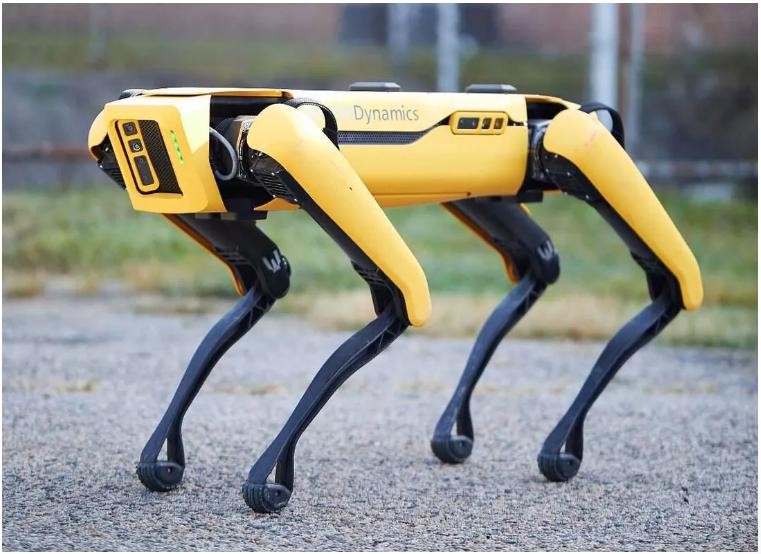


### **Overview**

This Colab notebook guides you through the task of learning to control SPOT for navigating in the SoC COM1 building. Here is the setup. A user signals high-level *intentions*,  FORWARD, LEFT, and RIGHT, to command SPOT to follow a route. Spot needs to determine its own real-time control, i.e., angular velocities, conditioned on the  user intention as well as real-time observations of the environment obtained from its front camera. You will train a neural network for the robot to complete this task.

You will use supervised learning, or also called "behaviour cloning". You will have access to a human demonstration dataset, constructed by a human expert directly controlling SPOT using a joystick, to navigate according to the high-level intention signaled by a user. The dataset contains 110,000   camera image frames and user intentions.  Each frame is labelled with the angular velocity that SPOT undertakes at the cooresponding situation. Labels of angular velocities are discretized into five bins, cooresponding to five different control classes: "hard left turn", "slight left turn", "forward", "slight right turn", and "hard right turn". Given the discretized labels, the control task becomes the problem of learning a mapping from the camera observation and the user intention to a suitable class of robot control. It is thus treated as a standard image classification task from the machine learning standpoint. 

After training, the robot would exhibit roughly the following behaviors:
* make hard turns at junctions or to avoid immediate collisions with  obstacles,
* make slight turns to conform to the shape of the corridor or prepare for hard turns,
* go straight when its heading is well-aligned with a clear corridor.

Consistent failures to  choose proper control would cause the robot to crash into the wall, obstacles, or people, while occasional failures may be recoverable.


This notebook consists of five main steps, to be executed in order.

1. *Preparation*. Check and set up the running environment: mount the google drive, create a project folder, install package dependency, ...

2. *Basic CNN Model*. Define a simple 
convolutional neural network (CNN) model that maps input images to descretized control decisions.

3. *Data Loading*. Provide a helper class to load the data for training the agent.

4. *Basic CNN Model Training*.  Run the script provided to train a basic CNN model. 

5. *Improving Prediction Performance*. Improve basic CNN model to achieve better performance for behaviour cloning in terms of the prediction accuracy.


**Remarks**
* If Colab is new to you, it may be worthwhile to go over the quick [introduction](https://colab.research.google.com/notebooks/intro.ipynb).

* The five steps should be executed **in order**, unless you are familiar with Colab and know what you are doing.

* Training with GPUs is much faster than that with CPUs only:  under the Colab notebook dropdown menu,  choose `Runtime/Change runtime type/GPU`.

* Maintain good Internet connection throughout to avoid disconnecting from the Colab.

* Do not idle your computer, as Colab automatically disconnects GPUs if the idle time is too long.

* If you have a good GPU on your personal computer, it is recommended to download the colab sheet as a python file and test your code on your local machine. The computational performance is usually better.



### **1. Preparation**



**Check Python version.**

In [1]:
!python -V

Python 3.9.16


**Check Cuda version.**

In [2]:
!nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


**Mount the Google drive.**

Mount your Google drive to store the dataset and the trained models.
Execute the cell below. Grant access to Google Drive when asked to do so.

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Create a project directory**

In [4]:
from os import path, chdir, getcwd, mkdir

# Choose a project name
projectName = "BehaviourCloning"

# Project directory is in My Drive
projectDirectory = "/content/drive/My Drive/" + projectName

# Checks if cwd is in content folder
if getcwd() == "/content":
  # Makes project directory if it does not exist
  if not path.isdir(projectDirectory):
    mkdir(projectDirectory)
    print(f"Project {projectName} has been created!")
  else:
    print(f"Project {projectName} already exist!")
  # Changes to project directory
  chdir(projectDirectory)

print(f"The current working directory is {getcwd()}")

Project BehaviourCloning already exist!
The current working directory is /content/drive/My Drive/BehaviourCloning


**Install dependencies.**

Note that we will conduct the evaluation using PyTorch version 1.13.1. It is important to ensure that the version of PyTorch used for development is consistent with the one used for evaluation. Using functions from other versions of PyTorch may result in errors during evaluation.

In [5]:
pip install torch torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Check GPU usage.**

In [7]:
# Check if runtime uses GPU
import torch

gpu_name = torch.cuda.get_device_name(0)
print("Using GPU", gpu_name)

Using GPU NVIDIA A100-SXM4-40GB


**Download the data set to your Google drive.**

The dataset requires about 400MB space. Please prepares sufficient space for downloading. Using the 'wget' command, you can also download the data onto your own machine. This allows you to have a local copy of the data for offline access and analysis.

In [121]:
from os import path, chdir, getcwd, mkdir
projectDirectory = "/content/drive/My Drive/BehaviourCloning"
chdir(projectDirectory)

!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=16DOwYORpKiXffxgzOIsfq6eA1qd6FW5i' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=16DOwYORpKiXffxgzOIsfq6eA1qd6FW5i" -O data.zip 

--2023-03-21 14:09:18--  https://docs.google.com/uc?export=download&confirm=t&id=16DOwYORpKiXffxgzOIsfq6eA1qd6FW5i
Resolving docs.google.com (docs.google.com)... 74.125.200.100, 74.125.200.138, 74.125.200.139, ...
Connecting to docs.google.com (docs.google.com)|74.125.200.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0k-3c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/1usjb11ql6he64stk7p177hlr73enfs3/1679407725000/16928826242900815371/*/16DOwYORpKiXffxgzOIsfq6eA1qd6FW5i?e=download&uuid=57b7a50f-6078-40ba-a556-1d43aa86bd24 [following]
--2023-03-21 14:09:18--  https://doc-0k-3c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/1usjb11ql6he64stk7p177hlr73enfs3/1679407725000/16928826242900815371/*/16DOwYORpKiXffxgzOIsfq6eA1qd6FW5i?e=download&uuid=57b7a50f-6078-40ba-a556-1d43aa86bd24
Resolving doc-0k-3c-docs.googleusercontent.com (doc-0k-3c-docs.googleusercontent.com)... 172.217.194.132,

**Unzip the dataset**

It may take few minutes to finish.

In [122]:
!unzip data.zip

Streaming output truncated to the last 5000 lines.
  inflating: images/454539.jpg       
  inflating: images/967320.jpg       
  inflating: images/317008.jpg       
  inflating: images/23826.jpg        
  inflating: images/1085186.jpg      
  inflating: images/1050898.jpg      
  inflating: images/522312.jpg       
  inflating: images/263225.jpg       
  inflating: images/933635.jpg       
  inflating: images/433844.jpg       
  inflating: images/330417.jpg       
  inflating: images/912454.jpg       
  inflating: images/727662.jpg       
  inflating: images/513243.jpg       
  inflating: images/980791.jpg       
  inflating: images/412835.jpg       
  inflating: images/403584.jpg       
  inflating: images/203240.jpg       
  inflating: images/429351.jpg       
  inflating: images/322949.jpg       
  inflating: images/417338.jpg       
  inflating: images/613329.jpg       
  inflating: images/321548.jpg       
  inflating: images/26958.jpg        
  inflating: images/312096.jpg       

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Remove the data.zip file to save space**

In [ ]:
projectDirectory = "/content/drive/My Drive/BehaviourCloning"
chdir(projectDirectory)
!rm data.zip # to save space

In [127]:
def flip(s):
    if s == 'left':
        s = 'right'
    elif s== 'right':
        s = 'left'
    return s

def save_flipped_copy(path, frame):
    print("Fipping image ", frame)
    im = Image.open(os.path.join(path, 'images', f'{frame}.jpg'))
    out = im.transpose(Image.FLIP_LEFT_RIGHT)
    out.save(os.path.join(path, 'images', f'{frame}_flipped.jpg'))

def augment_data(path):
    df = pd.read_csv(os.path.join(path, 'train.txt'), sep='  ')
    changed_df= df.copy()
    changed_df['frame'] = changed_df['frame'].astype(str)+'_flipped'
    changed_df['steering_wheel_angle'] = changed_df['steering_wheel_angle']*-1
    changed_df['dlm'] = df['dlm'].apply(lambda x: flip(x))
    changed_df.to_csv(os.path.join(path, 'train.txt'), header=None, index=None, sep=' ', mode='a')
    df['frame'].apply(lambda x: save_flipped_copy(path, x))


In [128]:
augment_data('.')

<ipython-input-127-384de4d741ca>:15: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(os.path.join(path, 'train.txt'), sep='  ')


Streaming output truncated to the last 5000 lines.
Fipping image  414105
Fipping image  961516
Fipping image  1090943
Fipping image  1088538
Fipping image  753231
Fipping image  121380
Fipping image  341046
Fipping image  300820
Fipping image  730819
Fipping image  962929
Fipping image  612381
Fipping image  206596
Fipping image  8923
Fipping image  1053647
Fipping image  980152
Fipping image  141287
Fipping image  961865
Fipping image  196226
Fipping image  915639
Fipping image  995967
Fipping image  63362
Fipping image  223011
Fipping image  970914
Fipping image  423769
Fipping image  965632
Fipping image  19133
Fipping image  917351
Fipping image  523434
Fipping image  503278
Fipping image  418665
Fipping image  412534
Fipping image  102981
Fipping image  1078539
Fipping image  519590
Fipping image  955128
Fipping image  110857
Fipping image  1087971
Fipping image  914531
Fipping image  432564
Fipping image  614512
Fipping image  166754
Fipping image  935737
Fipping image  923525
Fi

### **2. Dataset**

Our dataset consists of ~110k time frames of data collected by human controlling the SPOT robot to navigate in COM1, SOC. Features of each data point consist of the front-camera image at the cooresponding time frame and the intention (LEFT, FORWARD, RIGHT) the user had specified. The label of each data point is the control that SPOT conducted at the time frame to achieve the user intention. Each label falls in five control classes: "hard left turn", "slight left turn", "forward", "slight right turn", and "hard right turn", which coorespond to five evenly divided intervals of angular velocities. Particularly, angular velocities of hard turns have absolute values <= 0.7 and > 0.42 of the turning limit of SPOT; slight turns have absolute values <= 0.42 and > 0.14; forward motion have values <= 0.14.

Given the user intenton as context, the relationship between the camera observation and the robot control is still complex. For instance, human may command a LEFT intention far before reaching a junction, but the robot should keeping moving forward and start to turn only when at the junction. In other cases when obstacles in the corridor block the robot's way, the robot will have to avoid collisions in a way possibly contradicting with the user intention. The robot thus has to understand the environment according camera observations and determine the most appropriate behaviours.

Here are a few examples from the dataset:

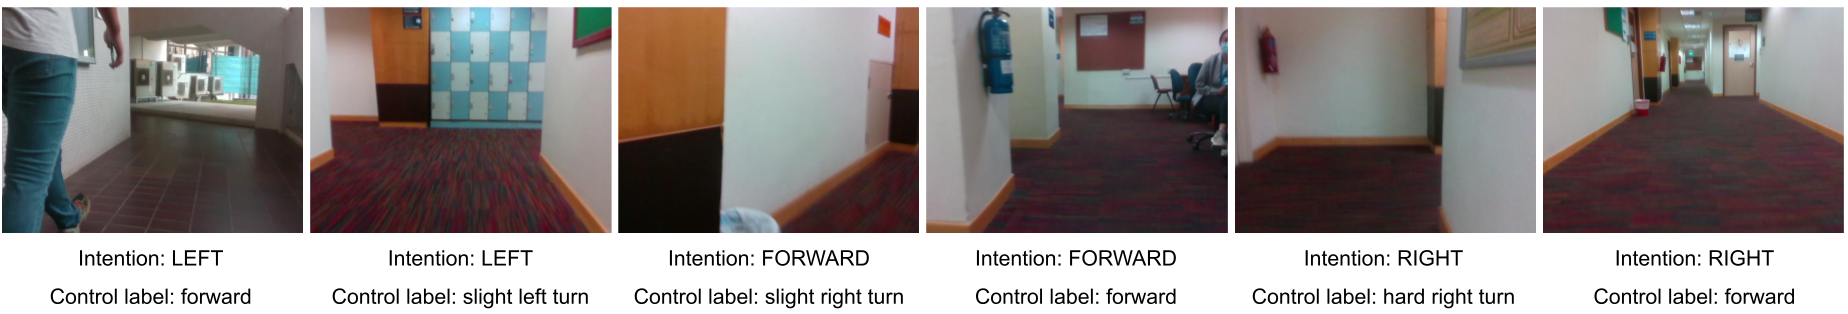

### **3. Basic CNN Model**

**Define the convolutional neural network (CNN) model for control prediction.**

<!-- In the earliner lecture, we talked about linear regression: fit input-output data pairs to a linear function.  -->
Here, we build a neural network that takes camera images and user intentions as input and outputs categorical distributions over the five control classes.
A linear function is not sufficient to capture the complex relationship between  input *images* and output control labels (angular velocities).   Instead, we use a neural network, which is capable of representing complex nonlinear functions. The neural network model consists of several convolution layers to extract featurs from  the images and full connnected layers to map image features to the final output. We also use one-hot encoding of the intentions as input to the FC layers.

Below defines a simple CNN model for demonstration.




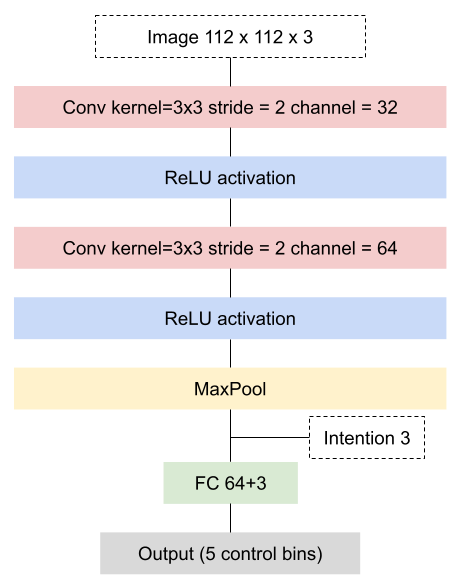

In [8]:
import torch.nn as nn
import torch.nn.functional as F

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

class MyModel(nn.Module):

    def __init__(self, num_bins=5):
        super().__init__()
        self.num_bins = num_bins

        # Build the CNN feature extractor
        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),

            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p=0.2),

            nn.AdaptiveMaxPool2d(output_size=(1, 1))
        )

        # Build a FC heads, taking both the image features and the intention as input
        self.fc = nn.Sequential(
                    nn.Linear(in_features=256+3, out_features=num_bins))

        print(f'A simple learner.')

    def forward(self, image, intention):
        # Map images to feature vectors
        feature = self.cnn(image).flatten(1)
        # Cast intention to one-hot encoding 
        intention = intention.unsqueeze(1)
        onehot_intention = torch.zeros(intention.shape[0], 3, device=intention.device).scatter_(1, intention, 1)
        # Predict control
        control = self.fc(torch.cat((feature, onehot_intention), dim=1)).view(-1, self.num_bins)
        # Return control as a categorical distribution
        return control

You can stack more convolutional layers (`nn.conv2d`) in the feature extractor `self.cnn` to make the model deeper. You may also change the number of output channels (`out_channels`) to make the CNN wider. Deeper and wider networks are generally more expressive and can represent more complex functions. 

You are permitted to utilize a pre-trained model, additional data, and more advanced architectures such as Transformer to enhance your approach in any way you see fit. There are no restrictions on the methods or tools that you can use to improve the performance of your model. It is essential that all the methods and tools used are thoroughly documented in your report as a good practice. This will help ensure transparency and allow others to reproduce your results.

Note that when modifying the architecture, you have to make sure that the `in_channels` of a layer equals to the `out_channels` of its preceding layer.



### **4. Data Loading**

In the following code, we create a data loader `MyDataset` to load our dataset from the hard disk to the memory. The Python class inherits the standard PyTorch `Dataset` class. It will return us a mini-batch of randomly sampled data at every `enumerate` operation. You will see the usage in our training code.   

In [9]:
import os
import cv2
import random
import math
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import Sampler
from torchvision import transforms
from torchvision.transforms import *
import sys

def read_image(path):
    return Image.open(path)

def crop_top_quarter(img):
      CROP_PERCENTAGE = 0.25
      w, h = img.size
      return img.crop((0, h*CROP_PERCENTAGE, w, h))


class MyDataset(Dataset):
    
    INTENTION_MAPPING = {'forward': 0, 'left': 1, 'right': 2}
    MAX_VELOCITY = 0.7
    MIN_VELOCITY = -0.7

    def __init__(self, is_train=True, num_bins=5):
        self.bin_size = (self.MAX_VELOCITY - self.MIN_VELOCITY) / num_bins

        self.data_dir = '.'

        if is_train:
            self.data = pd.read_csv(os.path.join(self.data_dir, 'train.txt'), delim_whitespace=True)
        else:
            self.data = pd.read_csv(os.path.join(self.data_dir, 'val.txt'), sep=' ')

        self.preprocess = Compose([
            #transforms.Lambda(crop_top_quarter),
            transforms.RandomRotation(10),
            Resize((112, 112)),
            ToTensor(),
            Normalize(mean=[0.5071, 0.4866, 0.4409], std=[0.2675, 0.2565, 0.2761])
        ])
        
        print(f'loaded data from {self.data_dir}. dataset size {len(self)}')

    def discretize_control(self, control):
        return int((control - self.MIN_VELOCITY) / self.bin_size)

    def __getitem__(self, idx):
        frame, _, _, angular_velocity, intention = self.data.iloc[idx]
        image = self.preprocess(read_image(os.path.join(self.data_dir, 'images', f'{frame}.jpg')))
        intention = torch.tensor(self.INTENTION_MAPPING[intention])
        label = torch.tensor(self.discretize_control(angular_velocity))

        return image, intention, label

    def __len__(self):
        return len(self.data)

### **5. Basic CNN Model Training**



**Set the working directory.**

In [10]:
from os import path, chdir, getcwd, mkdir
projectDirectory = "/content/drive/My Drive/BehaviourCloning"
chdir(projectDirectory)

**Start training.**

The first epoch is slow. With data caching, from the 2nd epoch it trains much faster.



In [11]:
import time
from datetime import datetime
import torch
import multiprocessing as mp
from torch.optim.lr_scheduler import ReduceLROnPlateau

class AverageMeter(object):
    """
    A utility class to compute statisitcs of losses and accuracies
    """

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def get_lr(optimizer):
    '''
    Get the current learning rate
    '''
    for param_group in optimizer.param_groups:
        return param_group['lr']


def topk_accuracy(k, outputs, targets):
    """
    Compute top k accuracy
    """
    batch_size = targets.size(0)

    _, pred = outputs.topk(k, 1, True)
    pred = pred.t()
    correct = pred.eq(targets.view(1, -1))
    n_correct_elems = correct.type(torch.FloatTensor).sum().item()

    return n_correct_elems / batch_size


def train():
    batch_size = 32
    num_epochs = 11
    num_workers = 10
    num_bins = 5

    model = MyModel(num_bins)
    model = nn.DataParallel(model.cuda().float())

    train_set = MyDataset(is_train=True, num_bins=num_bins)
    validation_set = MyDataset(is_train=False, num_bins=num_bins)

    train_loader = torch.utils.data.DataLoader(
        train_set, batch_size=batch_size, num_workers=num_workers, pin_memory=True, shuffle=True)
    validation_loader = torch.utils.data.DataLoader(
        validation_set, batch_size=batch_size, num_workers=num_workers, pin_memory=True, shuffle=False)

    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.001,  betas=(0.9, 0.999), eps=1e-08,)
    criterion = nn.CrossEntropyLoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1, factor=0.3)

    # training loop
    for epoch in range(num_epochs):
        start_time = time.time()
        train_loss, val_loss = AverageMeter(), AverageMeter()
        train_acc, val_acc = AverageMeter(), AverageMeter()

        # train loop
        model.train()
        for i, (image, intention, label) in enumerate(train_loader):
            image, intention, label = image.cuda(), intention.cuda(), \
                label.cuda().view(-1)

            prediction = model(image, intention)

            loss = criterion(prediction, label)
            train_loss.update(loss.item())

            acc = topk_accuracy(2, prediction, label)
            train_acc.update(acc)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            if i % 100 == 99:
                print(f'time:{datetime.now()} training: iteration {i} / {len(train_loader)}, avg train loss = {train_loss.avg:.4f}, '
                      f'train accuracy {train_acc.avg:.4f}')

        # validation
        model.eval()
        for i, (image, intention, label) in enumerate(validation_loader):
            image, intention, label = image.cuda(), intention.cuda(), \
                label.cuda().view(-1)            
            with torch.no_grad():
                prediction = model(image, intention)

                loss = criterion(prediction, label)
                val_loss.update(loss.item())

                acc = topk_accuracy(2, prediction, label)
                val_acc.update(acc)

            if i % 100 == 99:
                print(f'time:{datetime.now()} validation: iteration {i} / {len(validation_loader)}, avg val loss = {val_loss.avg:.4f}, '
                      f'val accuracy {val_acc.avg:.4f}')

        # epoch summary
        print(f'Epoch {epoch}, train error {train_loss.avg:.4f}, val error {val_loss.avg:.4f}. '
              f'Train acc = {train_acc.avg:.4f}, val acc = {val_acc.avg:.4f}. '
              f'Time cost {(time.time() - start_time) / 60:.2f} min.\n')

        # lr scheduler
        scheduler.step(val_loss.avg)

        # checkpoint
        if epoch % 2 == 1:
            torch.save(model.state_dict(), f'ckpt_e{epoch}.pt')


if __name__ == "__main__":
    train()


A simple learner.
loaded data from .. dataset size 194000
loaded data from .. dataset size 10000
time:2023-03-21 14:56:23.963441 training: iteration 99 / 6063, avg train loss = 2.3518, train accuracy 0.4456
time:2023-03-21 14:56:25.614395 training: iteration 199 / 6063, avg train loss = 1.9775, train accuracy 0.4634
time:2023-03-21 14:56:27.219504 training: iteration 299 / 6063, avg train loss = 1.8468, train accuracy 0.4750
time:2023-03-21 14:56:28.828119 training: iteration 399 / 6063, avg train loss = 1.7771, train accuracy 0.4874
time:2023-03-21 14:56:30.320876 training: iteration 499 / 6063, avg train loss = 1.7294, train accuracy 0.5010
time:2023-03-21 14:56:31.805450 training: iteration 599 / 6063, avg train loss = 1.6933, train accuracy 0.5116
time:2023-03-21 14:56:33.380080 training: iteration 699 / 6063, avg train loss = 1.6642, train accuracy 0.5214
time:2023-03-21 14:56:34.900766 training: iteration 799 / 6063, avg train loss = 1.6430, train accuracy 0.5302
time:2023-03-21 

This is our main training code. It performs training in the term of "epochs", where each epoch represents enumerating the full training dataset. In each epoch, we first train our model using mini batch gradient descent, then evaluate our model using the test data. For every two epochs, we save a checkpoint of our model to the hard disk.

The main hyper-parameters that need to be tuned for the learning task includes the learning rate ("lr" parameter of the optimizer), the size of mini batches ("batch_size"), and the L2 regularization factor ("weight_decay" parameter of the optimizer). For this vanilla implementation, it should take around 40 minutes for the training process.

### **6. Improving the Model**

The basic CNN model does not work very well on the training data. After 10 epochs of training, it achieves about 53% top-2 classification accuracy on the validation dataset over 5 angular velocity bins. Now, your task is to investigate why the basic CNN model does not perform well and improve the model to achieve higher prediction accuracy. Some specific suggestions are given below.





**Tune the learning algorithm.**  Hyperparameter tuning is important to neural network training. Try to adjust the following parameters in section 5 "basic CNN model training":

- Choice of [optimizer](https://pytorch.org/docs/stable/optim.html) (SGD, Adam, AdamW (Adam with proper weight decay), ...)
- Learning rate (0.1, 0.01, 0.001, 0.0001, ...)
- Number of epochs (should be sufficient to achieve converge)
- Batch size (32, 64, 128, 256, ...) (optional)

The learning rate typically has the largest impact on performance. When the learning rate is too large, it leads to unstable training (loss fluctuating or frozen at a high level). When it is too small, it leads to inefficient training (loss decreasing very slowly). You need to identify the best learning rate to allow both stable and efficient training.

The choice of optmizer can also largely affect the training and validation performance. Some optimizers perform better on training, while some optimizers are good at generalization. Note that the learning rate needs to be re-tuned after changing the optimizer.

**Improve feature extraction.** A good image feature extractor is key to good performance. Using deeper (with more layers) and wider (with more channels) networks typically make the feature extractor more powerful. However, when there are too many trainable parameters in a network, it also becomes susceptible to ["overfitting"](https://d2l.ai/chapter_multilayer-perceptrons/underfit-overfit.html#underfitting-or-overfitting), i.e., the model fits the training set perfectly (low loss, high accuracy) but fails to generalize to the validation set (high loss, low accuracy). 

You need to determine the optimal depth and the width of your feature extractor to acheive the best performance on the validation set.









There are many other techniques to improve  classification performance. Two common ones are described below. You may try these two or any others to improve the  performance further, particularly, for extra credits.

**Augment the data (optional)**. The augmentation technique artificially expands the size of a training dataset by creating modified versions of images. It creates variations of the images that can improve the  model's ability to generalize. 
You can augment the images by transforming the content, for example:
- Fliping the input image horizontally (as well as the user intention and the angular velocity label). This produces data for a "mirrored" environment.
- Slightly translating or rotating the image. This emulates slight variations of the orientation of SPOT's body. You may need to slightly crop the edges of input images to eliminate empty pixels produced by image transformation.
- Other meaningful transformations to introduce variantion to images in the dataset. 

Transformations in [`torchvision.transforms`](https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py) allows you to easily perform various types of image transformations. You can customize your data augmentation by adding more random transformations to `self.preprocessor`.

**Regularization (optional).**
If overfitting unfortunately happens, you can try the following techniques to adddress it and improve the generalization of your model:
- [L2 reguarization or weight decay](https://d2l.ai/chapter_multilayer-perceptrons/weight-decay.html). Weight decay regulates the weights of your network to be small values so that the model generalizes better. The scaling factor of the regularization term is controlled by the `weight_decay` parameter of the optimizer.
- [Dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) (nn.Dropout and nn.Dropout2d). Dropout randomly drops out some activations in the cooresponding hidden layer during training. This makes the network more difficult to train, but often easier to generalize.


### **Submission**



Create a single zip file `YourMatricNumber-Lab2.zip` (e.g., `A01234567-Lab2.zip` ) containg the following:

1. Colab notebook
 * Download your entire Colab notebook. Save it as an ipynb file and name it `YourMatricNumber-Notebook.ipynb`.
2. Neural network model class
  
  This file will be used to load your pretrained model and hence for evaluation.
 * Name the file  `Model.py`
 * See example code in  Section 3 Basic CNN Model above.
 * Do not change the inner class name and keep it as "MyModel".

3. Pretrained model
    - Name the file as `YourMatricNumber-Model.pt`
    - You can find the example code to save your model in Section 5 Basic CNN Model Training
    - Make sure you can load the model with the "MyModel" defined in `Model.py`.

    
4. Report
  * Describe briefly each attempt that you have made to improve the classification accuracy and the resulting performance gain.
  * Name the file as `YourMatricNumber.pdf`

Organize your submission folder strictly according to the following structure:
```
YourMatricNumber-Lab2.zip
|-- YourMatricNumber-Notebook.ipynb
|-- YourMatricNumber.pdf
|-- model_file
    |-- Model.py
    |-- YourMatricNumber-Model.pt
```

Your pre-trained model will be evaluated  on a set of unseen test images for classification accuracy. Make sure your pretrained model is **reproducible** from your Colab notebook.

Below is the example test script for  evaluation. You may use it to check your model's performance with the validation set. Of course, a different test image set will be used for the actual evaluation.

In [ ]:
projectDirectory = "/content/drive/My Drive/BehaviourCloning"
chdir(projectDirectory)

In [ ]:
import torch
from torch import nn
from your_python_file import MyModel, MyDataset, AverageMeter, topk_accuracy 
# Change [your_python_file] to the actual file containing the definitons of the classes


def test():
    my_model = MyModel()
    my_model = nn.DataParallel(my_model.cuda().float())
    my_model.eval()
    batch_size = 64

    my_model.load_state_dict(torch.load('my_model.pt'))
    test_set = MyDataset(is_train=False)

    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, \
                      shuffle=False)

    # test accuracy
    test_acc = AverageMeter()
    for i, (image, intention, label) in enumerate(test_loader):
        image, intention, label = image.cuda(), intention.cuda(), label.cuda().view(-1)
        with torch.no_grad():
            prediction = my_model(image, intention)
            acc = topk_accuracy(2, prediction, label)
            test_acc.update(acc)

        if i % 10 == 9:
            print(f'test: iteration {i} / {len(test_loader)}, '
                  f'test accuracy {test_acc.avg:.4f}')

    print(f'evaluation finished, test acc {test_acc.avg:.4f}')

if __name__ == "__main__":
    test()


ModuleNotFoundError: ignored